# Keras tutorial - the Happy House

Welcome to the first assignment of week 2. In this assignment, you will:
1. Learn to use Keras, a high-level neural networks API (programming framework), written in Python and capable of running on top of several lower-level frameworks including TensorFlow and CNTK. 
2. See how you can in a couple of hours build a deep learning algorithm.

Why are we using Keras? Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. Being able to go from idea to result with the least possible delay is key to finding good models. However, Keras is more restrictive than the lower-level frameworks, so there are some very complex models that you can implement in TensorFlow but not (without more difficulty) in Keras. That being said, Keras will work fine for many common models. 

In this exercise, you'll work on the "Happy House" problem, which we'll explain below. Let's load the required packages and solve the problem of the Happy House!

In [4]:
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, LeakyReLU, UpSampling2D, Conv2DTranspose 
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adagrad, Adam
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *
import h5py

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from random import shuffle
import glob

%matplotlib inline

Using TensorFlow backend.


In [5]:
def create_h5py_dataset(hdf5_path, train_path, dims, keyword):
    shuffle_data = True  # shuffle the addresses before saving

    # read addresses and labels from the 'train' folder
    addrs = glob.glob(train_path)

    labels = [1 if keyword in addr else 0 for addr in addrs]  # 0 = Cat, 1 = Dog

    if shuffle_data:
        c = list(zip(addrs, labels))
        shuffle(c)
        addrs, labels = zip(*c)

    # Divide the hata into 60% train, 20% validation, and 20% test
    train_addrs = addrs[0:int(0.6*len(addrs))]
    train_labels = labels[0:int(0.6*len(labels))]
    val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
    val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]
    test_addrs = addrs[int(0.8*len(addrs)):]
    test_labels = labels[int(0.8*len(addrs)):]

    train_shape = (len(train_addrs), dims[0], dims[1], 3)
    val_shape = (len(val_addrs), dims[0], dims[1], 3)
    test_shape = (len(test_addrs), dims[0], dims[1], 3)

    # open a hdf5 file and create earrays
    hdf5_file = h5py.File(hdf5_path, mode='w')
    hdf5_file.create_dataset("train_img", train_shape, np.int8)
    hdf5_file.create_dataset("val_img", val_shape, np.int8)
    hdf5_file.create_dataset("test_img", test_shape, np.int8)
    hdf5_file.create_dataset("train_labels", (len(train_addrs),), np.int8)
    hdf5_file["train_labels"][...] = train_labels
    hdf5_file.create_dataset("val_labels", (len(val_addrs),), np.int8)
    hdf5_file["val_labels"][...] = val_labels
    hdf5_file.create_dataset("test_labels", (len(test_addrs),), np.int8)
    hdf5_file["test_labels"][...] = test_labels

    # loop over train addresses
    for i in range(len(train_addrs)):
        addr = train_addrs[i]
        img = cv2.imread(addr, -1)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # add any image pre-processing here

        # save the image and calculate the mean so far
        hdf5_file["train_img"][i, ...] = img[None]
        #mean += img / float(len(train_labels))

In [6]:
# Create forest dataset
hdf5_f_path = "images/forestdb"  # address to where you want to save the hdf5 file
train_f_path = 'images/forest/*.jpg'
dims = (256, 256)
create_h5py_dataset(hdf5_f_path, train_f_path, dims, 'forest')

In [7]:
# Inspect dataset
hdf5_f_file = h5py.File(hdf5_f_path, "r")
data_num = hdf5_f_file["train_img"].shape[0]
print(hdf5_f_file["train_img"].shape)

FX_train = np.array(hdf5_f_file["train_img"]) / 255

# Labels
FY_train = hdf5_f_file["train_labels"]

(90, 256, 256, 3)


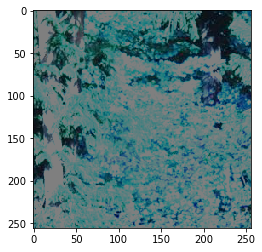

In [8]:
plt.imshow(FX_train[1])
plt.show()

In [9]:
# Create highway dataset
hdf5_h_path = "images/highwaydb"  # address to where you want to save the hdf5 file
train_h_path = 'images/highway/*.jpg'
dims = (256, 256)
create_h5py_dataset(hdf5_h_path, train_h_path, dims, 'highway')

In [10]:
# Inspect dataset
hdf5_h_file = h5py.File(hdf5_h_path, "r")
data_num = hdf5_h_file["train_img"].shape[0]
print(hdf5_h_file["train_img"].shape)

HX_train = np.array(hdf5_h_file["train_img"]) / 255

# read labels and convert to one hot encoding
HY_train = hdf5_h_file["train_labels"]
hdf5_h_file.close()

(153, 256, 256, 3)


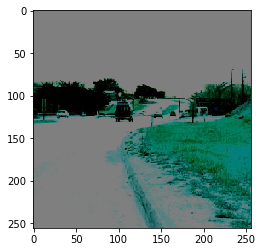

In [11]:
plt.imshow(HX_train[0])
plt.show()

In [12]:
hx_train = (HX_train.astype(np.float32) - 127.5)/127.5
m = HX_train.shape[0]
#pixels = HX_train.shape[1] * HX_train.shape[2] * HX_train.shape[3]
#hx_train = hx_train.reshape(m, pixels)

print("Training set shape is", hx_train.shape)

Training set shape is (153, 256, 256, 3)


In [13]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [14]:
def Discriminator_NN(input_shape):
    X_input = Input(input_shape)

    # Convolution
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0', momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)
    X = MaxPooling2D((2, 2), name='mp0', padding="same")(X)
    
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1', momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)
    X = MaxPooling2D((2, 2), name='mp1', padding="same")(X)
    
    X = Conv2D(128, (1, 1), strides = (1,1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2', momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)
    X = MaxPooling2D((2, 2), name='mp2', padding="same")(X)

    X = Flatten()(X)
    X = Dense(1048, activation='relu', name='fc1')(X)
    X = Dense(1048, activation='relu', name='fc2')(X)
    X = Dense(1, activation='sigmoid', name='output')(X)
    
    D = Model(inputs = X_input, outputs = X, name='D')
    D.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ["accuracy"])
    return D
    
"""
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
"""
D = Discriminator_NN((256, 256, 3))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 127, 127, 32)      896       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 127, 127, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 127, 127, 32)      0         
_________________________________________________________________
mp0 (MaxPooling2D)           (None, 64, 64, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 31, 64)        18496     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 31, 31, 64)        256       
__________

In [15]:
def Generator_NN(input_shape):
    X_input = Input(input_shape)

    # Convolution
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0', momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)
    X = MaxPooling2D((2, 2), name='mp0')(X)

    X = Conv2D(128, (3, 3), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1', momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)
    #X = MaxPooling2D((2, 2), name='mp1')(X)
    X = Conv2D(256, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2', momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)

    #X = UpSampling2D()(X)
    X = Conv2DTranspose(128, 3, padding='same')(X)
    X = BatchNormalization(momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)

    X = UpSampling2D()(X)
    X = Conv2DTranspose(64, 3, padding='same')(X)
    X = BatchNormalization(momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)
    
    X = UpSampling2D()(X)
    X = Conv2DTranspose(32, 3, padding='same')(X)
    X = BatchNormalization(momentum=0.9)(X)
    X = LeakyReLU(0.2)(X)
    
    X = UpSampling2D()(X)
    X = Conv2DTranspose(3, 3, padding='same')(X)
    G = Model(inputs = X_input, outputs = X, name='G')
    G.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ["accuracy"])
    return G

G = Generator_NN((256, 256, 3))
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 262, 262, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 130, 130, 64)      1792      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 130, 130, 64)      256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 130, 130, 64)      0         
_________________________________________________________________
mp0 (MaxPooling2D)           (None, 65, 65, 64)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 128)       73856     
__________

In [16]:
def create_gan(discriminator, generator, input_shape):
    D.trainable=False
    gan_input = Input(shape=input_shape)
    x = G(gan_input)
    gan_output= D(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(D,G, (256, 256, 3))
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
G (Model)                    (None, 256, 256, 3)       499523    
_________________________________________________________________
D (Model)                    (None, 1)                 9715273   
Total params: 10,214,796
Trainable params: 498,179
Non-trainable params: 9,716,617
_________________________________________________________________


In [17]:
def plot_generated_images(epoch, G, examples=5, dim=(256, 256), figsize=(256, 256)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 256, 256, 3])
    generated_images = G.predict(noise)
    #generated_images = generated_images.reshape(10,128,128)
    plt.figure()
    for i in range(generated_images.shape[0]):
        plt.savefig('gan_generated_image %d-d.png' %{epoch, i})

In [18]:
import tqdm

In [ ]:
def training(epochs=50, batch_size=20, input_shape = (256, 256, 3)):

    # Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    batch_count = hx_train.shape[0] / batch_size
    
    # Creating GAN
    G = Generator_NN(input_shape)
    D = Discriminator_NN(input_shape)
    gan = create_gan(D, G, input_shape)
    
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm.tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 256, 256, 3])
            
            # Generate fake MNIST images from noised input
            generated_images = G.predict(noise)
            
            # Get a random set of  real images
            image_batch =hx_train[np.random.randint(low=0,high=hx_train.shape[0],size=batch_size)]

            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            D.trainable=True
            D.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 256, 256, 3])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            D.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, G)

training()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1
